In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
from random import choices, choice
import time
from statistics import mode

### Questions
* should the bootstrapped datasets be the same size as the original dataset? or smaller?
* do i need an instance var for the datasets or just the OOB samples for each tree?

### To Do
* use consistent vocabulary (predictor vector vs list vs. features, etc...)
* function to pretty print tree
* experiment to improve accuracy (# predictors?)
* clean up code to make more concise (use list comprehensions instead of loops)
* compare this RF with sci-kit learn functions
* delete old code, unnecessary print statements

<img src="forest.jpg">

#### Overview
In this article, I will explain how to build a random forest classifier from scratch using only basic Python code (no scikit-learn functions or other black box methods). 

To understand random forests, you first need to known how a decision tree works. A decision tree is a data structure used to classify new data points. You can visualize it as an upside-down tree with one main root node. This is where we begin with a training dataset. The data is split on a certain feature and value, resulting in two branch nodes. Each of those nodes is similarly split, and this process continues until the final split. The last split results in terminal or leaf nodes, which contain a classification for the data point in question. This is a very simple explanation of how decision trees work.

When building the tree, we use a training dataset to determine the best feature and value at which to split the data at each node. Once the tree is built (trained), we can use it to predict classifications for new data points and to evaluate the tree's accuracy or error rate. One decision tree on its own is prone to overfitting the data and is likely to have high variance. It will not perform well with new data, especially if there is no limit set on the number of times the data can be split (this is called the depth of the tree).

In order to improve accuracy and reduce the impact of overfitting, we can train many decision trees on subsets of the same dataset. This collection of decision trees is known as a random forest. The "random" part of its name refers to two key elements:

1. taking one dataset and randomly sampling it many times to create many datasets, none of which is exactly the same as any other
2. using a random sample of predictors for each tree

In practice, random forest classifiers are a highly accurate method for classification problems. [Click here](https://statquest.org/statquest-decision-trees/) for an excellent introduction to decision trees and [here](https://statquest.org/statquest-random-forests-part-1-building-using-and-evaluating/) for more information about random forests.

#### Loading Data

We begin by reading a csv file and saving it in two lists. For each row in the dataset, we save the predicting variables to one list and the response variable to another list. What we end up with is a list of lists, X, which contains predicting variables for all data points, and another list, y, which contains the classifications for each datapoint in the X list. We further split the data to create training and testing sets. It is important to test our classifier on new data that it has not previously seen, to get an exact measure of how accurately it classifies new data.

In [3]:
# load data and save feature and class vectors
X = []
y = []

# load data
#with open("Breast_cancer_data.csv", newline="") as f:
with open("loanSample.csv", newline="") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        X.append([float(num) for num in line[0:-1]]) # save predictors to X list
        y.append(int(line[-1])) # save class to y list

# Break data into training and testing sets
X_train = X[:4000]
X_test = X[4000:5000]
y_train = y[:4000]
y_test = y[4000:5000]

print("First five rows of predicting variables (training set):")
for i in range(5):
    print(X_test[i])
print()
print("First five classes (training set):", y_test[:5])

First five rows of predicting variables (training set):
[69317.0, 98599.0, 71.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[35039.0, 65697.0, 55.41, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[43394.0, 73851.0, 59.58, 10.0, 3.0, 1.0, 69664.0, 93929.0, 93929.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14926.0, 0.0, 1.0, 0.0, 0.0]
[59647.0, 68616.0, 89.92, 1.0, 1.0, 0.0, 8461.0, 8461.0, 8461.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1558.0, 0.0, 1.0, 0.0, 1.0]
[55659.0, 64836.0, 87.91, 2.0, 2.0, 0.0, 12991.0, 20646.0, 20646.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3442.0, 1600.0, 2.0, 0.0, 2.0]

First five classes (training set): [0, 0, 1, 0, 1]


### Utility functions
With the data loaded, we can begin creating the DecisionTree class. First, there are a number of utility functions that support this class. These functions help with splitting the data, which can be broken down into several steps.

#### Entropy
First, given a list of response variables/classes, we need to determine the entropy, which is our measure of how heterogenous or pure each node in the tree is. The formula for entropy is:

> $-{\sum}_j p_j log_2 p_j$

Where $j$ is the number of classes in the dataset. Since we have a binary response variable (0 or 1), $j = 2$ for our data.

To put it more simply, we use the probabilities for each possible classification to determine how mixed the node is. We want to split the data in a way that will reduce the entropy of the set. In a tree that classifies the training data perfectly, each leaf would have an entropy of 0, meaning that each leaf contains only one class. A tree like this would be overfit, so we will put a limit on the number of times the data can be split (this limit is an instance variable for the tree, called max_depth). Gini index is another metric for assessing the heterogeneity of a set of datapoints. [Click here](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb) for a detailed explanation of both entropy and Gini metrics.

In [7]:
# calculate cost function for split (entropy)
def calc_entropy(y_vals):
    ent = 0
    for y_val in set(y_vals):
        prop = len([val for val in y_vals if val==y_val]) / len(y_vals)
        ent += (-1 * prop) * np.log2(prop) # update entropy using formula
    return ent

#### Information Gain
Next, given a node and a potential split for its data, we need to determine whether we should split the node or leave it as a terminal/leaf node. To do this we need to know the affect on entropy of the split: will entropy be reduced by further splitting the data in the node, and by how much? Thus we have a function that calculates the information gain, or change in entropy.

In [8]:
# calculate information gain
def calc_infogain(parent_yvals, left_yvals, right_yvals):
    H = calc_entropy(parent_yvals) # entropy of parent node
    H_left = calc_entropy(left_yvals) # entropy of left child node
    H_right = calc_entropy(right_yvals) # entropy of right child node
    P_left = len(left_yvals) / len(parent_yvals)
    P_right = len(right_yvals) / len(parent_yvals)
    cond_entropy = (H_left * P_left) + (H_right * P_right) # conditional entropy to compare to parent node
    return H - cond_entropy # difference between parent node and child node entropy

#### Splitting the Data

We also need a function that finds the best way to split the data. The "best way" is the way that reults in the highest information gain. In other words, the split that reduces entropy the most and results in nodes containing classes that are as similar as possible. This will result in a better classification for new datapoints. To do this, we select a random subset of predictor variables of size $m$ and iterate over them. A common value for $m$ is $\sqrt{p}$, where $p$ is the total number of predictors. For each predictor in the subset, we find the information gain if we split on the mean value for that predictor. Once we find the predictor and value that result in the maximum information gain, we know that's the best way to split the data.

Putting all these functions together, we can take a dataset, determine the best way to split it, and split it into two new nodes. The split function takes several parameters:

* the index of the predictor to split on
* the value for that predictor that should be used to split the data
* the predictors vector and class vector to be split

Then, for each data point, we look at the given predictor and check whether its value is less than the given value:

* If it's less than the value, it goes into the left vector
* If not, it goes into the right vector
* The corresponding class from the class vector is similarly put into either the left or right vector

The function returns both the left and right predictor and class vectors (4 in total) in the form of a dictionary.

In [9]:
# determine best split (or no split)
def best_split(X, y):
    m = int(np.round(np.sqrt(len(X[1])),2)) # set number of predectors to test = sqrt total # predictors
    pred_idxs_to_test = np.random.choice(range(0,len(X[1])),m, replace=False) # select random subset of predictors to test
    pred_vals_to_test = np.mean(X, axis=0)[pred_idxs_to_test] # use mean value for each predictor as split value
    best_idx = 0
    best_val = 0
    max_infogain = 0
    X_left, X_right, y_left, y_right = [], [], [], []
    for i in range(len(pred_idxs_to_test)): # for each predictor in random subset
        X_l, X_r, y_l, y_r = split_data(pred_idxs_to_test[i], pred_vals_to_test[i], X, y) # split data on mean value for each predictor
        infogain = calc_infogain(y, y_l, y_r)
        if infogain > max_infogain: # determine if split increases information gain / reduces entropy
            max_infogain = infogain
            best_idx = pred_idxs_to_test[i]
            best_val = pred_vals_to_test[i]
            X_left, y_left = X_l, y_l
            X_right, y_right = X_r, y_r
    return {"pred_idx": best_idx, "pred_val": best_val, "left": {"X_left": X_left, "y_left": y_left}, "right": {"X_right": X_right, "y_right": y_right}}

# split data
def split_data(pred_idx, pred_val, X_vals, y_vals):
        X_left, X_right, y_left, y_right = [], [], [], []
        for i in range(len(X_vals)):
            if X_vals[i][pred_idx] < pred_val:
                X_left.append(X_vals[i])
                y_left.append(y_vals[i])
            else:
                X_right.append(X_vals[i])
                y_right.append(y_vals[i])
        return X_left, X_right, y_left, y_right

#### Evaluating Predictions

The last utility function takes a list of predictions and a list of labels and simply calculates the accuracy rate for the predictions.

In [10]:
# calculate accuracy of predictions
def calc_accuracy(y_hat, y):
    correct = []
    for i in range(len(y_hat)):
        correct.append(y_hat[i]==y[i])
    return sum(correct) / len(y_hat)

<img src="tree.jpg">

### Decision Tree Summary

For each branch of the decision tree, we look at the datapoints in that branch and determine the best predictor and predictor value at which to split the data. We split the data into two nodes using that predictor and value. Then we take the resulting nodes and split each of them in the same way. The final left and right branches are called terminal or leaf nodes. The leaf nodes contain the classification for a data point. Once the tree is trained, its structure can be followed for a new data point, travelling down and following either the left or right branch depending on the value of each predictor in the new data point.

With a single decision tree, we would build it and then prune it back, removing nodes as needed to achieve the highest possible accuracy when predicting on new data. Pruning minimizes the effects of overfitting, which is likely to occur with a single tree. When building trees as part of a random forest, however, pruning is not needed. It's acceptable for individual trees to be overfit, since overall the forest will have a lower prediction error rate than the individual trees.

The decision tree class takes as a parameter max_depth, which is the maximum number of times the original data can be split. The instance variable, self.tree, holds a dictionary that is populated using data passed to the build_tree method once the tree is instantiated.

The structure of the tree is as follows:

* Each key/value pair is either a predictor index, predictor value, left branch or right branch
* Branches are dictionaries as well
* Each branch has key/value pairs that mimic the original structure (predictor index, predictor value, left and right branch)
* Leaf nodes have left and right values of either 0 or 1 depending on the class assigned by the tree

Here are the key methods of the DecisionTree class:
* build_tree:
    - This method takes the predictors and class vectors as well as a parent node, and then it calls the grow_tree function.
* grow_tree
    - This method takes the data and calls the best_split utility function to find the best initial split for the data.
    - The nodes returned by the best_split function become the left and right branch of the decision tree.
* split_tree
    - This method calls itself in a recursive fashion and builds the decision tree, adding another layer of depth each time it is called.
    - It takes a node, a parent node, and the current depth of the tree.
    - For each branch (left and right) of the node, it checks whether there is data in the node.
    - If further branching is needed, a new node is created with the best_split utility function, the original node's data becomes the parent node, and the function calls itself on the new node and parent node.
    - This occurs until one of three posibilities takes place:
        * In the case of an empty node, a leaf node is created that contains the most common classification from the parent node.
        * In the case of maximum depth reached, a leaf node is created that contains the most common classification from the original data that was in that node.
        * In the case of a single data point in a node, a leaf node is created that contains that data point's class.
    - When the decision tree is built and all data split as needed, self.tree has been populated and the function returns
* predict
    - This method takes a new data point and follows the structure of the tree to determine which class to predict.
    - It returns the class for the new data point.

In [13]:
class DecisionTree(object):
    # create new instance of DecisionTree
    def __init__(self, depth):
        self.max_depth = depth
        self.tree = {}
    
    # build decision tree
    def build_tree(self, X, y, parent={}, depth=0): # does this need to take a parent node? or only split_tree needs that?
        
        # grow decision tree
        def grow_tree(X, y):
            self.tree = best_split(X, y) # get root node with best split for full data
            parent = {} # begin with empty parent node
            split_tree(self.tree, parent, 1) # call recursive function to build tree

        # split tree, called recursively
        def split_tree(node, parent_node, d):

            # save data from node to be used in split if needed
            left, right = node["left"], node["right"]

            # delete data from node so can reassign best classification
            del(node["left"], node["right"])

            # check if node contains empty dataset
            if len(left["X_left"])==0 or len(right["X_right"])==0:
                # assign each branch of the node to the most common class from the parent node
                node["left"] = max(set(parent_node["left"]["y_left"]), key=parent_node["left"]["y_left"].count)
                node["right"] = max(set(parent_node["right"]["y_right"]), key=parent_node["right"]["y_right"].count)
                return

            elif d >= self.max_depth: # check if tree has been split maximum number of times
                # assign each branch of the node to the most common class from this node
                node['left'] = max(set(left['y_left']), key=left['y_left'].count)
                node['right'] = max(set(right['y_right']), key=right['y_right'].count)
                return
            else:
                # check left and right datasets to see if need to split more or make terminal node
                # assess left node
                if len(set(left["y_left"]))==1:
                    # assign each branch of the node to the most common class from this node
                    node['left'] = max(set(left['y_left']), key=left['y_left'].count)
                else:
                    # split this branch by calling split_tree function
                    node["left"] = best_split(left["X_left"], left["y_left"])
                    parent = {"left": left, "right": right}
                    split_tree(node["left"], parent, d+1)
                # assess right node
                if len(set(right["y_right"]))==1: 
                    # assign each branch of the node to the most common class from this node
                    node['right'] = max(set(right['y_right']), key=right['y_right'].count)
                    return
                else:
                    # split this branch by calling split_tree function
                    node["right"] = best_split(right["X_right"], right["y_right"])
                    parent = {"left": left, "right": right}
                    split_tree(node["right"], parent, d+1)
        
        # call grow_tree to create decision tree
        grow_tree(X, y)
                
    # predict classification for new datapoint
    def predict(self, x):
        curr_node = self.tree # start at the root node
        while True:
            if x[curr_node['pred_idx']] < curr_node['pred_val']: # determine which branch to follow
                if type(curr_node['left'])==int: # if a terminal node is reached
                    return curr_node['left'] # return that classification
                else:
                    curr_node = curr_node['left'] # if a terminal node is not reached, continue down the tree
                    continue
            else:
                if type(curr_node['right'])==int: # if a terminal node is reached
                    return curr_node['right'] # return that classification
                else:
                    curr_node = curr_node['right']  # if a terminal node is not reached, continue down the tree
                    continue

#### Evaluating Individual Tree

We can test the performance of an individual decision tree and also see the impact of changes in max_depth on a tree's accuracy. Each time this code block runs, the plot will look slightly different given the randomness in selecting predictors to split on. However, the trend in the plot remains consistent: as the depth of the tree increases, the testing accuracy decreases. This shows the impact of overfitting on testing accuracy and highlights the usefullness of a random forest instead of a single decision tree for classification: we will get the benefits of a decision tree without the drawback of overfitting.

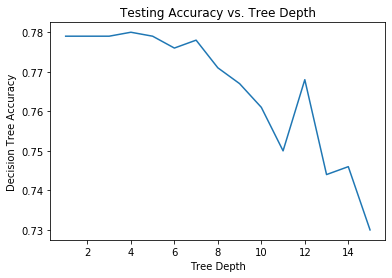

In [37]:
# test one tree: 
#mytree = DecisionTree(4)
#mytree.build_tree(X_train, y_train)
#print("tree: ", mytree.tree)

accuracies = []
for i in range(15):
    # build tree of given max_depth using training data
    mytree = DecisionTree(i + 1)
    mytree.build_tree(X_train, y_train)

    # test predict
    preds = []
    for i in range(len(X_test)):
        preds.append(mytree.predict(X_test[i])) # use tree to predict on test data
    
    accuracies.append(calc_accuracy(preds, y_test)) # calculate accuracy

# plot accuracy as a function of tree depth
max_depths = [i+1 for i in range(15)]  
plt.plot(max_depths, accuracies)

plt.xlabel('Tree Depth')  
plt.ylabel('Decision Tree Accuracy')
plt.title('Testing Accuracy vs. Tree Depth')

plt.show()  

#### Random Forest Summary

In the RandomForest class, a given number of decision trees are built using bootstrapped datasets (explained below). The accuracy rates of all trees are aggregated to determine the overall accuracy of the forest.

The first step, known as bootstrapping, is taking one dataset and creating new datasets from it by randomly sampling the points in the original set with replacement. For example, if we only had one dataset with points A, B, C, and D, and we wanted to create three bootstrapped datasets, we might have one with A, B, B, C, one with A, C, D, D, and one with B, C, C, D. We use the bootstrapped sets to train the decision trees in the random forest.

The second random element in a random forest is the random sample of predicting variables used in each decision tree. As explained previously, instead of using all predictors in all trees, we randomly select a certain number ($m$) of them. In this example we use $\sqrt{p}$ as the value for $m$.

In each bootstrapped dataset, a certain number of the original datapoints will be left out. They are known as the out-of-bag samples, and we use them to get predictions from the trees that did not use them in training. The most common prediction for each unseen data point is the overall prediction from the random forest. This method of aggregating the predictions for each out-of-bag sample is known as bootstrapped aggregating, or bagging.

Additionally, for each tree in the forest, its accuracy can be assessed using these left out data points, because they are unseen data for that tree. The average accuracy achieved by all trees in the forest in this way is known as the out-of-bag accuracy. It is useful because it reduces the variance of the random forest in comparison with an individual decision tree. [This lecture](https://www.youtube.com/watch?v=lq_xzBRIWm4&list=PL5-da3qGB5IB23TLuA8ZgVGC8hV8ZAdGh) gives an excellent explanation of bagging as it relates to building a random forest.

In [62]:
# take a predictors vector and class vector, create bootstrapped datasets

class RandomForest():
    def __init__(self, num_trees=100, depth=10): # default depth?
        self.max_depth = depth
        self.num_trees = num_trees
        #self.datasets = [] # don't need instance variable for datasets, just oob samples
        self.oob_Xs = []
        self.oob_ys = []
        self.forest = []
    
    # return one bootstrapped dataset from given data
    def bootstrap(self, X, y):
        sample_idxs = choices(range(len(X)), k=len(X))
        bsX = [X[idx] for idx in sample_idxs]
        bsY = [y[idx] for idx in sample_idxs]
        # add data not included in boostrapped sample to oob_data list
        oob_xs = []
        oob_ys = []
        for i in range(len(X)):
            if X[i] not in bsX:
                oob_xs.append(X[i])
                oob_ys.append(y[i])
        #self.oob_data.append((oob_xs, oob_ys))
        self.oob_Xs.append(oob_xs)
        self.oob_ys.append(oob_ys)
        return bsX, bsY

    # return list of bootstrapped datasets (1 for each tree in forest)
    def get_datasets(self, X, y):
        bootstrap_sets = []
        for i in range(self.num_trees): # for each tree in the forest
            bootstrap_sets.append(self.bootstrap(X, y)) # get boostrapped sample, add to list
        return bootstrap_sets

    # grow forest
    def grow_forest(self, X, y):
        datasets = self.get_datasets(X, y) # get bootstrapped datasets to use building trees
        #self.datasets = self.get_datasets(X, y) # get bootstrapped datasets to use building trees (maybe don't need instance var for this)
        for i in range(self.num_trees): # for each tree and each dataset
            tree = DecisionTree(self.max_depth)
            #tree.build_tree(X, y)
            tree.build_tree(datasets[i][0], datasets[i][1]) # build tree with next bootstrapped dataset
            #tree.build_tree(self.datasets[i][0], self.datasets[i][1]) # build tree with next bootstrapped dataset
            # is this where i need to get oob predictions?
            self.forest.append(tree) # add tree to forest
    
    # evaluate accuracy rate of random forest classifier
    def calc_oob_accuracy(self):
        tot_accuracy = 0
        for i in range(self.num_trees): # for each tree in the forest
            preds = []
            for x in self.oob_Xs[i]: # for each row in that tree's oob sample
                preds.append(self.forest[i].predict(x)) # use that tree to get a prediction for that row
            tot_accuracy += calc_accuracy(preds, self.oob_ys[i]) # keep running total of accuracy
        return tot_accuracy / self.num_trees # return average accuracy across all trees
    
    # predict classification for new data
    def predict(self, x):
        preds = []
        # for each tree in this forest
        for tree in self.forest:
            # predict this data point with that tree
            # add the prediction to the list
            preds.append(tree.predict(x))
        # return the most common prediction from all trees
        try:
            return mode(preds)
        # if there's a tie, randomly select one class to return
        except:
            print("tie")
            return choice(list(set(preds)))

#### Building a Random Forest

In the following code blocks, we will create a new instance of the RandomForest class, grow the forest using training data, and calculate the out of bag accuracy. I also include timing functions to get a sense of how long this code takes to run.

In [63]:
# build forest
myForest = RandomForest(num_trees=100, depth=10)
start_forest = time.perf_counter()
myForest.grow_forest(X_train, y_train)
finish_forest = time.perf_counter()
forest_time = np.round(finish_forest - start_forest, 4)

# assess accuracy
start_oob = time.perf_counter()
oob_accy = myForest.calc_oob_accuracy()
finish_oob = time.perf_counter()
oob_time = np.round(finish_oob - start_oob, 4)

# print results
print("Forest was grown in ", forest_time, " seconds.")
print("OOB accuracy was calculated in ", oob_time, " seconds.")
print("OOB accuracy: ", np.round(oob_accy * 100, 2), "%")

Forest was grown in  106.4427  seconds.
OOB accuracy was calculated in  0.8918  seconds.
OOB accuracy:  74.66 %


<img src="evaluation.png">

#### Evaluating the Forest

Finally, let's test this random forest's accuracy by using it to classify new data.

In [68]:
# test forest on new data
test_preds = []
for x in X_test:
    test_preds.append(myForest.predict(x))

forest_accuracy = np.round(calc_accuracy(test_preds, y_test), 4)
print("random forest testing accuracy: ", forest_accuracy*100, "%")

random forest testing accuracy:  77.7 %


#### Next Steps
In time there are changes and additions I would like to make to this code so it can do more with a greater variety of data. Here are some examples:

* modify code to accept categorical (vs. only numerical) predicting variables
* use similar code to build regression tree from scratch

#### References
https://www.kaggle.com/gauravdesurkar/lt-vehicle-loan-default-prediction

http://www.cs.cmu.edu/afs/cs.cmu.edu/academic/class/15381-s06/www/DTs.pdf

https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8

https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8

https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb

https://www.dataschool.io/15-hours-of-expert-machine-learning-videos/